# Problem 1: Bayesian Density Estimation
By: Griffin Hosseinzadeh (2025 May 6)  
Inspired by a notebook by LM Walkowicz (2019 June 14)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization as viz
#from astropy.visualization import hist as viz_hist
from scipy import stats
from sklearn.neighbors import KernelDensity

Here I'm simulating some data. Just run this cell to generate a list of values `x`.

In [63]:
x = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
x = x[(x > -15) & (x < 15)]

Make a histogram of these values using `plt.hist`. (Use `density=True` throughout this exercise, so the y-axes are comparable.) How many peaks does this data set have?

Text(0.5, 1.0, 'histogram of probability density')

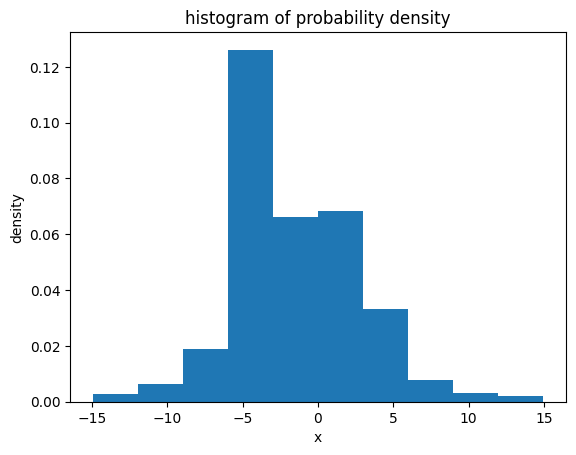

In [64]:
plt.hist(x, density= True)
plt.xlabel('x')
plt.ylabel("density")
plt.title("histogram of probability density")# complete

#this has one peak

Now make a histogram using the `'auto'` binning in Matplotlib. What does it think the right number of bins should be? How many peaks does this data set have?

42 bins


Text(0.5, 1.0, 'histogram of probability density')

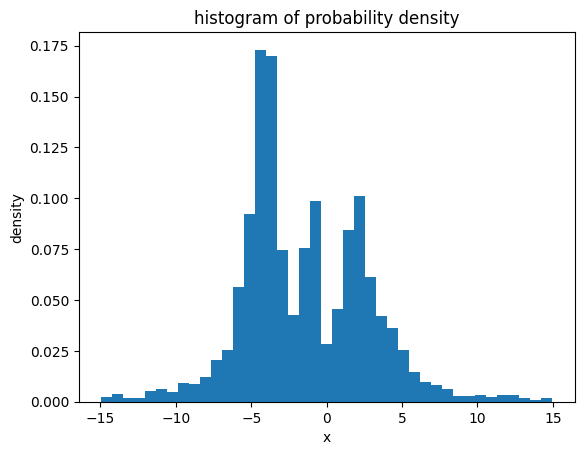

In [65]:
n, b, p = plt.hist(x, bins = 'auto', density =  True)
print(len(b), 'bins')
plt.xlabel('x')
plt.ylabel("density")
plt.title("histogram of probability density")# complete

#this has 3 peaks and matplotlib gives it 41 bins

Increase the number of bins even further. Is there a point where it gets too high? If so, why?

Text(0.5, 1.0, 'histogram of probability density')

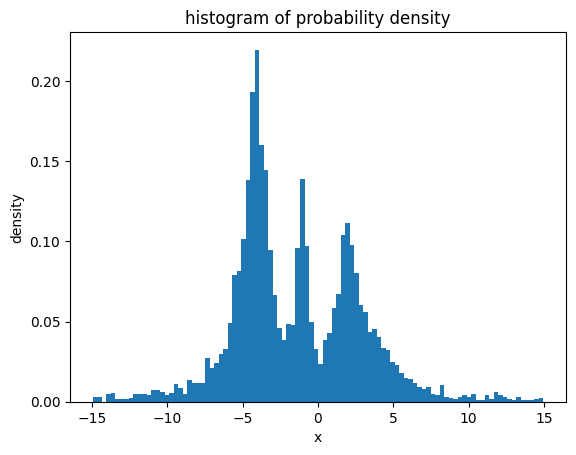

In [66]:
n, b, p = plt.hist(x, bins = 100, density =  True)
plt.xlabel('x')
plt.ylabel("density")
plt.title("histogram of probability density")# complete

Text(0.5, 1.0, 'histogram of probability density')

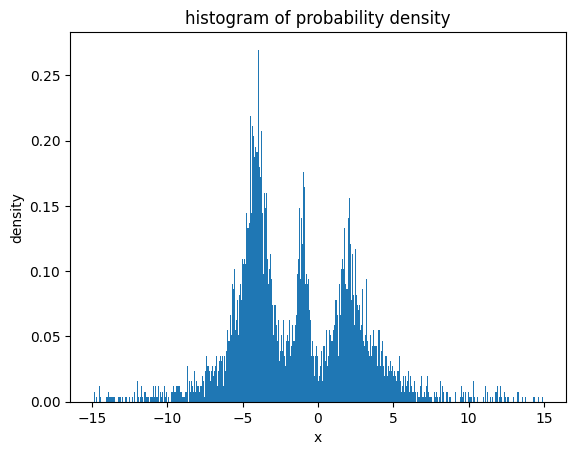

In [67]:
n, b, p = plt.hist(x, bins = 500, density =  True)
plt.xlabel('x')
plt.ylabel("density")
plt.title("histogram of probability density")# complete

In [68]:
#any more bins than the auto means the histogram takes too long to run and creates lots of mini spikes, so smaller peaks form that arent actucally peaks in the physical system, but just formed by variance in the data

Now make a histogram using Bayesian blocks. Hint: try the `astropy.visualization.hist` function. How many bins does this have? Can you see all the peaks?

20 bins


Text(0.5, 1.0, 'histogram of probability density')

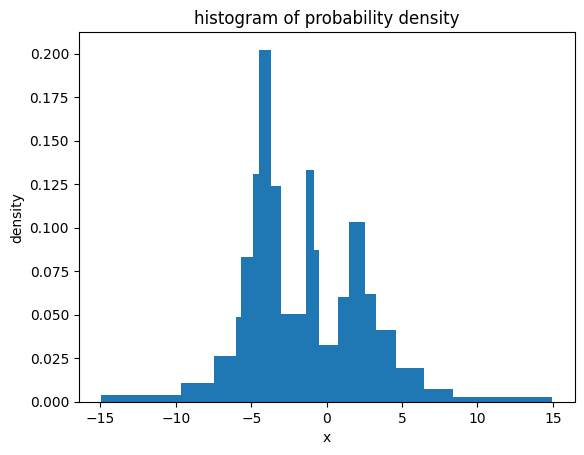

In [69]:
n, b, p = viz.hist( x, bins = 'blocks', density =  True)
print(len(b), 'bins')
plt.xlabel('x')
plt.ylabel("density")
plt.title("histogram of probability density")# complete

#this still has 3 peaks

Try making the Bayesian blocks histogram *without* `density=True`. What do you notice? Is this a good idea?

20 bins


Text(0.5, 1.0, 'histogram of probability')

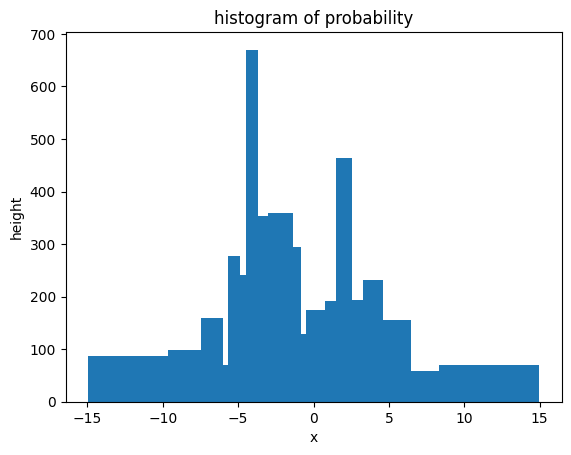

In [70]:
n, b, p = viz.hist( x, bins = 'blocks')
print(len(b), 'bins')
plt.xlabel('x')
plt.ylabel("height")
plt.title("histogram of probability")

#print(n)


#i dont thinks removing density is good as the max value is 10 times greater than the minimum, so we cannot have a good resolution of data

Now let's try making a KDE instead. Try a few different values for the bandwidth until you find one you like.

Text(0.5, 1.0, 'histogram of probability density')

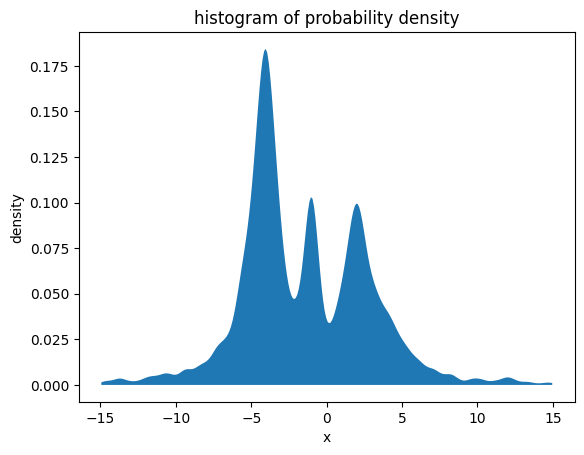

In [71]:
kde = KernelDensity(bandwidth=.35, kernel = 'gaussian')
kde.fit(x[: , np.newaxis])

min_x = np.min(x)
max_x = np.max(x)

#x_fit = np.arange(np.min([x],np.max([x])))
x_fit = np.arange(min_x,max_x,0.1)
lim = np.newaxis
y_fit =  np.exp( kde.score_samples(x_fit[:, lim]))

plt.fill_between( x_fit, y_fit)
#plt.plot(x_fit,y_fit)
plt.xlabel('x')
plt.ylabel("density")
plt.title("histogram of probability density")

#plt.hist(x, bins = 'auto', density =  True)

Plot all of these density estimates on top of each other using `histtype='step'` and compare them.

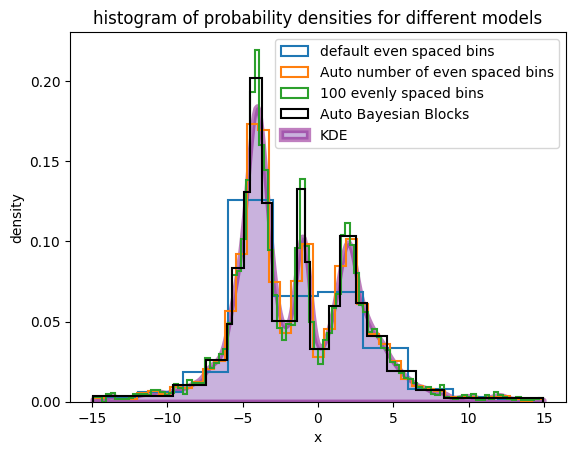

In [72]:
plt.hist(x, density= True, label = 'default even spaced bins',  histtype = "step", linewidth = 1.5)
plt.hist(x, bins = 'auto', density =  True, label = 'Auto number of even spaced bins',  histtype = "step", linewidth = 1.5)
plt.hist(x, bins = 100, density =  True, histtype = "step", linewidth = 1.5, label = "100 evenly spaced bins")
viz.hist( x, bins = 'blocks', density =  True,histtype='step', linewidth=1.5, color='black', label='Auto Bayesian Blocks')

#viz.hist( x, bins = 'blocks',histtype='step', linewidth=2, color='black', label='Bayesian Blocks')
#viz.hist( x, bins = 'blocks')
#viz.hist( x, bins= 10, density =  True,histtype='step', linewidth=1.5, color='pink', label='Bayesian Blocks')

plt.fill_between( x_fit, y_fit, ec="purple", linewidth=3.8, label='KDE',alpha=0.5)

plt.xlabel('x')
plt.ylabel("density")
plt.title("histogram of probability densities for different models")
plt.legend()
plt.show()

# Problem 2: Gaussian Process Regression
By: Griffin Hosseinzadeh (2019 April 17)  
Updated 2025 May 6

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import george
from astropy.table import Table

## Read the Light Curve
I have given you light curve data for the Type Ibn supernova PTF11rfh in the file `PTF11rfh.table`, which is readable with the `astropy.table` module. (Hint: `format='ascii.fixed_width'`.) For this example, let's fit the light curve in counts rather than magnitudes. Select only points observed in the $r$ or $R$ filter and have a measurement in counts. Plot it to see what we're working with. (For non-astronomers, MJD is a measure of time in days.)

In [74]:
data = Table.read("PTF11rfh.table", format = 'ascii.fixed_width')
#data2 = data[(data['filt']== "R")] + data[(data['filt']=='r')]
data2 = data[(data['filt']== "R") | (data['filt']=='r')]
data2.remove_row(16) #removing row with no counts data
data2

MJD,counts,dcounts,zp,nondet,filt,source,mag,dmag,limmag,flam,dflam
float64,float64,float64,float64,str5,str4,str5,float64,float64,float64,float64,float64
55889.091,19.7,36.8,27.0,True,R,P48,21.89257731651705,nan,--,--,--
55889.125,22.2,45.1,27.0,True,R,P48,21.671755508505942,nan,--,--,--
55889.167,-7.8,49.6,27.0,True,R,P48,21.56849267197535,nan,--,--,--
55891.167,-17.1,54.8,27.0,True,R,P48,21.46024546698992,nan,--,--,--
55892.099,99.8,107.9,27.0,True,R,P48,20.724643251493568,nan,--,--,--
55892.142,-128.1,64.0,27.0,True,R,P48,21.291746928241125,nan,--,--,--
55892.178,-13.6,107.1,27.0,True,R,P48,20.732723186121206,nan,--,--,--
55893.098,-57.5,56.9,27.0,True,R,P48,21.419416197213167,nan,--,--,--
55893.136,-85.3,64.3,27.0,True,R,P48,21.28666943089029,nan,--,--,--


Text(0, 0.5, 'counts (magnitude)')

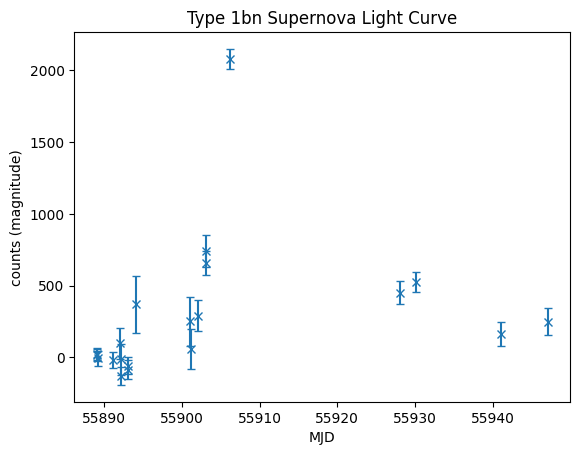

In [75]:
x =  data2['MJD']
y =  data2['counts']
dy =  data2['dcounts']
#plt.plot(x,y, marker= "o")
plt.errorbar(x,y,dy, fmt = "x", capsize = 3)
plt.title("Type 1bn Supernova Light Curve")
plt.xlabel("MJD")
plt.ylabel('counts (magnitude)')



## Try a Polynomial Fit
Hint: use `np.polyfit` and `np.polyval`. Try different degree polynomials to see if you are able to get a good fit.

Text(0, 0.5, 'counts')

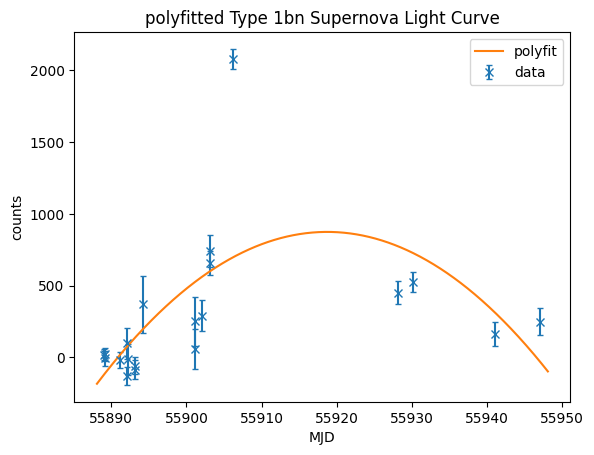

In [76]:
n = 2 #degree of polyfit

x_fit =  np.linspace(np.min(x)-1,np.max(x)+1,1000)
p = np.polyfit(x,y,n
              )
y_fit_poly =  np.polyval(p, x_fit)

plt.errorbar(x,y,dy,fmt = "x", label ="data",capsize=2)
plt.plot(x_fit,y_fit_poly, label=("polyfit"))
plt.legend()
plt.title("polyfitted Type 1bn Supernova Light Curve")
plt.xlabel("MJD")
plt.ylabel("counts")
# plot
# plot

Don't spend too much time on this. I could not get it to give a reasonable result.

## Try a Gaussian Process
We are using a package called `george` to make Gaussian process regression easier. It has all of the functions you need build in.

First we need to initialize a kernel (`george.kernels`). You should normalize the kernel by the total variance of the data points. Think about what hyperparameters would be appropriate for fitting your data. We can always optimize them later.

In [77]:
var_y = np.var(y)
kernel =  var_y * george.kernels.ExpSquaredKernel(72.0)
print(kernel)

ConstantKernel(log_constant=12.344509181681563, ndim=1, axes=array([0])) * ExpSquaredKernel(metric=Metric(72.0, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)


Initialize a Gaussian process with the kernel you chose. This is all contained within the `george.GP` object, which we will use for the remainder of the calculations.

In [78]:
gp =  george.GP(kernel)

The first step is to precompute the covariance matrix at the observed times.

In [79]:
gp.compute(x,dy)

The second and last step is to use the Gaussian process to predict the light curve at the times in `x_fit`, given the observed data points in `y`. This should give you an interpolation **and** and uncertainty on the interpolation.

In [80]:
mu , var = gp.predict(y, x_fit, return_cov = False ,  return_var = True)
std_dev = np.sqrt(var)

Plot the results of your Gaussian process fit and compare to the data and the polynomial fit. Hint: display the uncertainties using `plt.fill_between`.

In [81]:
sd_m1 = mu - std_dev 
sd_m2 = mu - 2 * std_dev
sd_m3 = mu - 3 * std_dev
sd_p1 = mu + std_dev
sd_p2 = mu + 2 * std_dev
sd_p3 = mu + 3 * std_dev

sd_p10 = mu + 10* std_dev 
sd_m10 = mu - 10 * std_dev

Text(0, 0.5, 'counts')

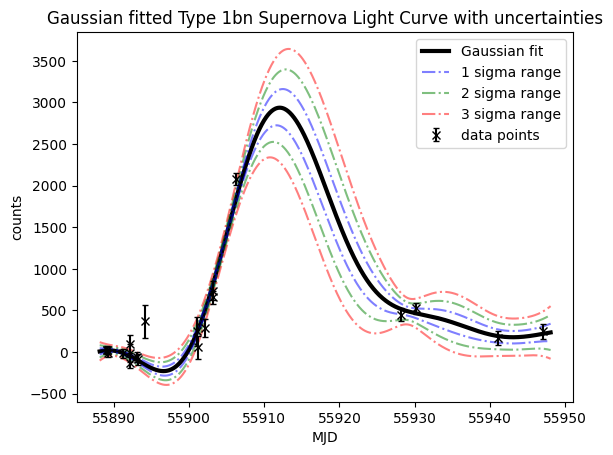

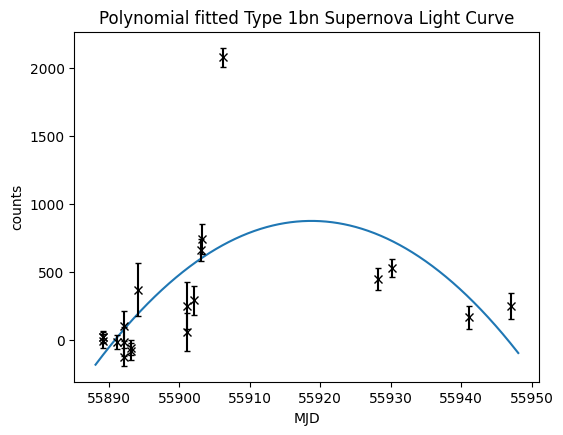

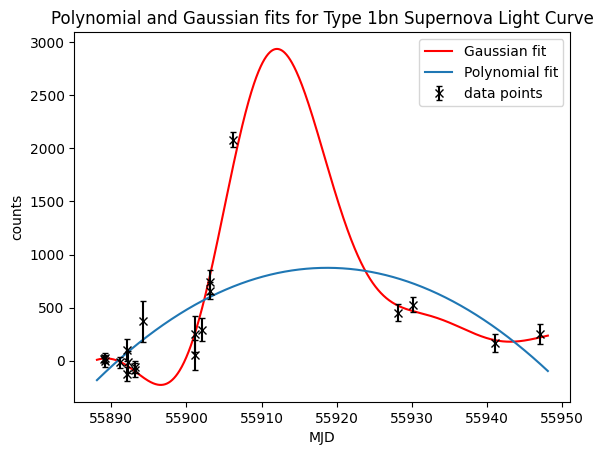

In [88]:
#figure, axis = plt.subplots(2, 1)

plt.errorbar(x,y,dy,capsize = 2,c="black", fmt = "x", label = "data points", zorder =3)
plt.plot(x_fit, mu, label="Gaussian fit", linewidth= 3,zorder =2, c= "black" )
#plt.fill_between(x_fit,sd_m1,sd_p1, alpha = 0.5, label= "1 sigma result")
#plt.fill_between(x_fit,sd_m2,sd_p2, alpha = 0.5, label= "2 sigma result")
#plt.fill_between(x_fit,sd_m3,sd_p3, alpha = 0.5, label= "3 sigma result")

plt.plot(x_fit,sd_m1, alpha = 0.5, ls = "-.", label= "1 sigma range", c = "blue")
plt.plot(x_fit,sd_p1, alpha = 0.5, ls = "-.", c = "blue")
plt.plot(x_fit,sd_m2, alpha = 0.5, ls = "-.", label= "2 sigma range", c = "green")
plt.plot(x_fit,sd_p2, alpha = 0.5, ls = "-.", c = "green")
plt.plot(x_fit,sd_m3, alpha = 0.5, ls = "-.", label= "3 sigma range", c = "red")
plt.plot(x_fit,sd_p3, alpha = 0.5, ls = "-.", c= "red")

#plt.plot(x_fit,sd_m10, alpha = 0.5, ls = "-.", label= "10 sigma range", c = "yellow")
#plt.plot(x_fit,sd_p10, alpha = 0.5, ls = "-.", c= "yellow")

#plt.fill_between(x_fit,sd_m2,sd_p2, alpha = 0.5, label= "2 sigma result")
#plt.fill_between(x_fit,sd_m3,sd_p3, alpha = 0.5, label= "3 sigma result")

#plt.fill_between(x_fit,sds, alpha = 0.5, label= "2 sigma result")
#plt.fill_between(x_fit,sds, alpha = 0.5, label= "3 sigma result")
plt.legend()
plt.title("Gaussian fitted Type 1bn Supernova Light Curve with uncertainties")
plt.xlabel("MJD")
plt.ylabel("counts")


plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 2)
plt.plot(x_fit,y_fit_poly, label=("polyfit"))
plt.errorbar(x,y,dy,capsize = 2,c="black", fmt = "x", label = "data points", zorder =3)
plt.title("Polynomial fitted Type 1bn Supernova Light Curve")
plt.xlabel("MJD")
plt.ylabel("counts")

plt.figure()
plt.errorbar(x,y,dy,capsize = 2,c="black", fmt = "x", label = "data points", zorder =3)
plt.title("Polynomial and Gaussian fits for Type 1bn Supernova Light Curve")
plt.plot(x_fit, mu, label="Gaussian fit",zorder =2, c= "red" )
plt.plot(x_fit,y_fit_poly, label=("Polynomial fit"))
plt.legend()
plt.xlabel("MJD")
plt.ylabel("counts")

Once you get a reasonable fit, try adjusting the kernel and/or hyperparameters to see what effects they have.

In [83]:
#A lower number input when making the kernel, gives tighter fit to the data, but a higher uncertainty on the gaussian parameters, giving a line with higher uncertainty and a wider sigma range

## Take-Away Message
Gaussian process regression is a very easy and powerful way to interpolate an arbitrary set of data points with a nonparametric function. Furthermore, it gives you uncertainties on the interpolation and handles covariance between points correctly.

## Other Things to Try (Optional)
- Optimize the Gaussian process using the technique described in the George tutorial: https://george.readthedocs.io/en/latest/tutorials/first/.
- Marginalize over the hyperparameter(s) using MCMC.
- Try products of different kernels to see if you can get a better fit.